# From Simple to Builder: Create Your Own Boson Sampler

MerLins's QuantumLayer offers much more flexibility that what the ``simple()`` method's is offering. Indeed,
it is possible to adapt the interferometer of the layer to our desires easily with the CircuitBuilder.

Run the following imports.

In [ ]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_digits, load_iris
from sklearn.model_selection import train_test_split

import merlin as ML

torch.manual_seed(0)
np.random.seed(0)

## ``simple()`` recap: classifying iris

The ``simple()`` method can be usefull for small classification tasks. Here, we can use it to classify the infamous Iris dataset which has 4 features and three flower types.

Let's first load the data.

In [54]:
iris = load_iris()
X = iris.data.astype("float32")
y = iris.target.astype("int64")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 112 samples
Test size: 38 samples


We can then easily create a quantum layer with the ``simple()``method.

In [55]:
quantum_classifier = ML.QuantumLayer.simple(input_size=4, output_size=3)

quantum_classifier

SimpleSequential(
  (quantum_layer): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (post_processing): ModGrouping()
)

We can use this layer as ``torch.Module`` to classify the dataset.

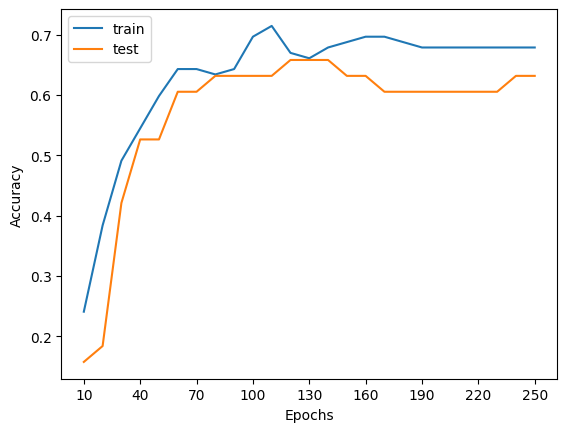

In [56]:
# Simple model training and evaluation process.
def run_experiment(layer: torch.nn.Module, epochs: int = 60, lr: float = 0.05):
    optimizer = torch.optim.Adam(layer.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        layer.train()
        optimizer.zero_grad()
        logits = layer(X_train)
        loss = F.cross_entropy(logits, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    layer.eval()
    with torch.no_grad():
        train_preds = layer(X_train).argmax(dim=1)
        test_preds = layer(X_test).argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()
        test_acc = (test_preds == y_test).float().mean().item()
    return losses, train_acc, test_acc


# Running the experiment
test_accs, train_accs = [], []
epochs = [10 * i for i in range(1, 26)]
for epoch in epochs:
    simple_layer = deepcopy(quantum_classifier)
    losses, train_acc, test_acc = run_experiment(simple_layer, epochs=epoch, lr=0.01)
    test_accs.append(test_acc)
    train_accs.append(train_acc)

# Plotting function
plt.plot(epochs, train_accs, label="train")
plt.plot(epochs, test_accs, label="test")
ticks = epochs
indexes_to_pop = []
index = 0
for i in range(len(epochs)):
    if i % 3 > 0:
        ticks.pop(index)
    else:
        index += 1

plt.xticks(ticks=ticks, labels=[str(p) for p in ticks])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## When does ``simple()`` becomes not appropriate?

The use of the ``simple()`` method is perfect for beginners in photonic QML who just want to explore the quantum advantages on easy and small datasets. However, we will need to use the full power of the QuamtumLayer to classify more complex and usefull datasets. Indeed, the method only works for datasets that have 20 or less features. Also, as stated in the [Fock State-enhanced Expressivity of Quantum Machine Learning Models](https://arxiv.org/abs/2107.05224) paper by Gan *et al*, the expressivity of a photonic quantum layer is directly related to the number of photons. The ``simple()`` method does not allow the user to change in input state of the interferometer.

We will present another easily to use tool to add a QuantumLayer to your torch modules that lets you control the input photons without any feature restrictions.

## Transition to ``merlin.CircuitBuilder``

Lets introduce MerLin's powerful ``CircuitBuilder``. This object can be directly passed to a quantum layer. For a specified number of modes, we can create many interferometer patterns. Lets go deeper to the available patterns.

First, lets create an instance of this object.

In [57]:
circuit_builder = ML.CircuitBuilder(n_modes=2)

circuit_builder

### A) ``add_rotations()``

If we want to add simple rotations on given modes, we can use the ``add_rotations()`` method. We can make the parameters trainable and define the starting angle if necessary. 

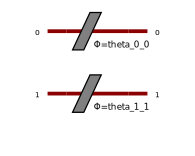

In [58]:
circuit_builder.add_rotations(modes=[0, 1], trainable=True, angle=0.36)

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

### B) ``add_superposition()``

If we want to add a simple interaction on given modes, we can use the ``add_superposition()`` method. We can make the parameters trainable, define the starting angles if necessary. 

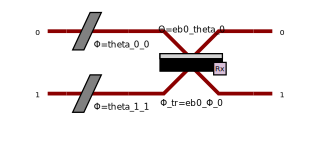

In [59]:
circuit_builder.add_superpositions(modes=[0, 1], theta=0.1, phi=0.15, trainable=True)

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

### C) ``add_entangling_layer()``

If we want a more complex interactions between the modes, we can add an entangling layer. This layer can represent every single interactions between the modes. The parameters can also be trainable. There are two patterns being "mzi" and "bell". Here we will use the default one being "mzi".

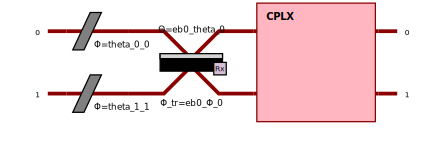

In [60]:
circuit_builder.add_entangling_layer(modes=[0, 1], trainable=True, model="mzi")

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

### Encoding

Just as simple does, we can add angle encoding to the interferometer. It is how and where the features will be assigned in the boson sampler on a forward pass. It is easy to add with a simple call of the ``add_angle_encoding()`` method.

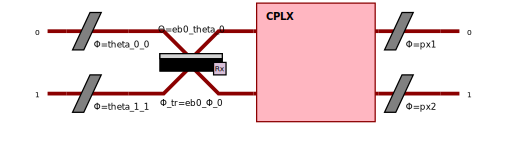

In [61]:
circuit_builder.add_angle_encoding(modes=[0, 1])

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

## Create a ``QuantumLayer`` from the ``CircuitBuilder``

To test the new way of using a QuantumLayer, we will try to classify ``scikit.learn``'s ``load_digits`` dataset. It is composed of 8x8 images of hand-written numbers 0 through 9. So, it has 64 features per image, much more than ``simple()`` can handle. It is still an easy dataset to classify in theory.

Let's load the dataset

In [62]:
digits = load_digits()
X = digits.data.astype("float32")
y = digits.target.astype("int64")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 1347 samples
Test size: 450 samples


With the tools presented in the last section, let's build a QuantumLayer to classify the ``load_digits`` dataset.

With circuit builder we can now specify the number of photons or the input state of the circuit. Here we will explore if the load_digits dataset is classified better with a more expressive neural network.

Let's create a circuit with 8 modes and 8 angle encoding layers.

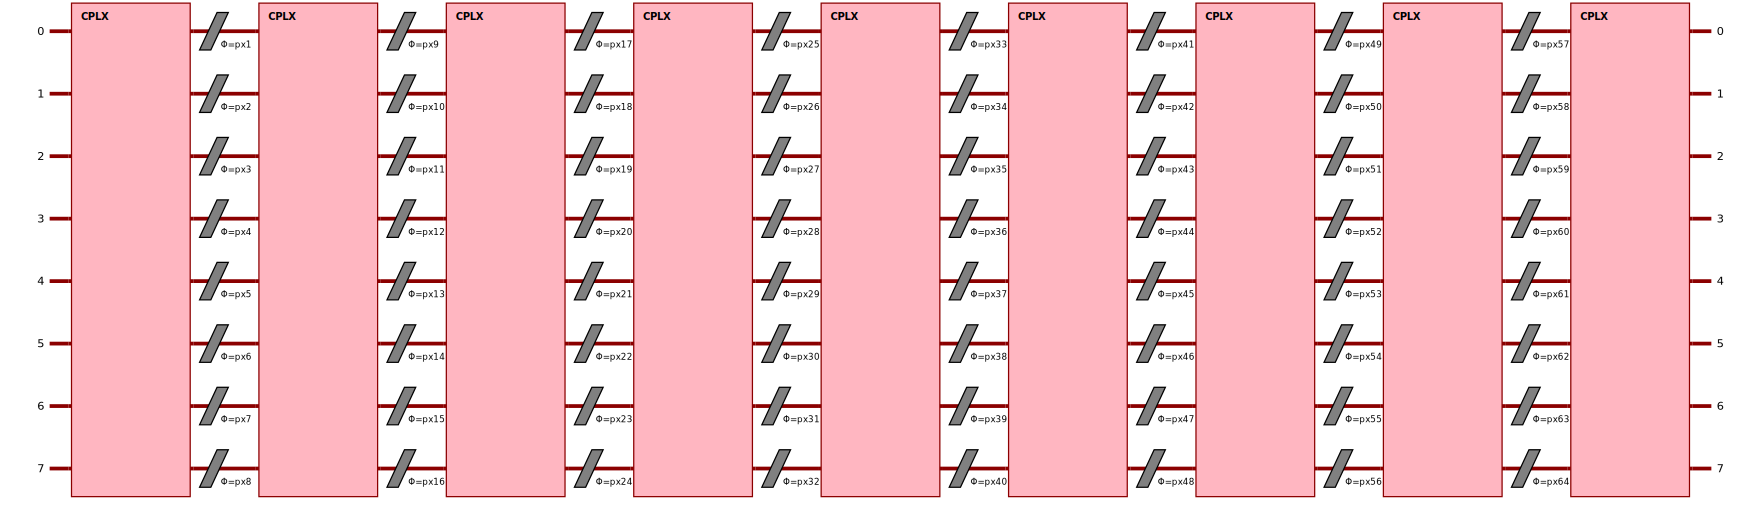

In [63]:
circuit = ML.CircuitBuilder(n_modes=8)

circuit.add_entangling_layer()
for _ in range(8):
    circuit.add_angle_encoding()
    circuit.add_entangling_layer()

pcvl.pdisplay(circuit.to_pcvl_circuit())

Let's analyze the relation between the number of photons and the performance of the circuit on the given dataset. To give the right output size, we will use a ``ML.ModGrouping``strategy to make sure was have an output dimension of 10. It combines the outputs of the quantum circuit in a dimension 10 vector (one dimension per class).

In [64]:
# A simple training experiment
def run_experiment(layer: torch.nn.Module, epochs: int = 60, lr: float = 0.05):
    optimizer = torch.optim.Adam(layer.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        layer.train()
        optimizer.zero_grad()
        logits = layer(X_train)
        loss = F.cross_entropy(logits, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    layer.eval()
    with torch.no_grad():
        train_preds = layer(X_train).argmax(dim=1)
        test_preds = layer(X_test).argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()
        test_acc = (test_preds == y_test).float().mean().item()
    return losses, train_acc, test_acc

The model with 1 had a training loss of 2.0487518310546875, a training accuracy of 0.5924276113510132 and a testing accuracy of 0.54666668176651.
The model with 2 had a training loss of 2.1770167350769043, a training accuracy of 0.49517446756362915 and a testing accuracy of 0.41111111640930176.
The model with 3 had a training loss of 2.2507216930389404, a training accuracy of 0.36005938053131104 and a testing accuracy of 0.17777778208255768.
The model with 4 had a training loss of 2.2558348178863525, a training accuracy of 0.3615441620349884 and a testing accuracy of 0.13555555045604706.


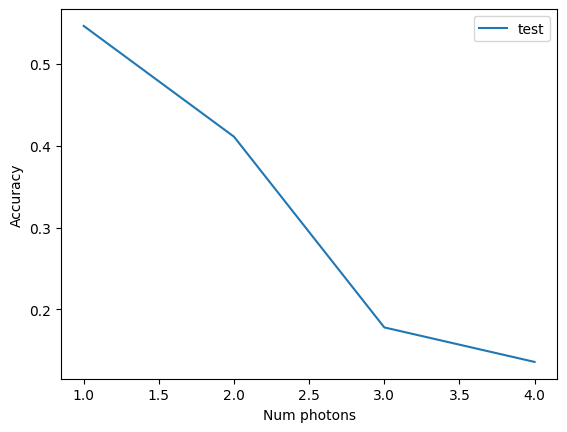

In [65]:
test_accuracies = []

for num_photons in [1, 2, 3, 4]:
    qcirc = ML.QuantumLayer(builder=deepcopy(circuit), n_photons=num_photons)
    quantum_classifier = nn.Sequential(qcirc, ML.ModGrouping(qcirc.output_size, 10))

    losses, train_acc, test_acc = run_experiment(
        quantum_classifier, epochs=100, lr=0.01
    )

    test_accuracies.append(test_acc)

    print(
        f"The model with {num_photons} had a training loss of {losses[-1]}, a training accuracy of {train_acc} and a testing accuracy of {test_acc}."
    )


# Plotting function)
plt.plot([1, 2, 3, 4], test_accuracies, label="test")
plt.xlabel("Num photons")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can conclude here that a bigger expressivity is not always benificial to a classification task as the less expressive classifier performs better here on the ``load_digits`` dataset.

Here you go! You are now ready to take advantage of the full power of MerLin's ``QuantumLayer``! The next step in your journey would be to investigate the different data encoding in the quantum circuits which can be found on the angle amplitude encoding page.